# Hand Recognition
### Filipe Borba  
### Franklin W. Olin College of Engineering
### Data Science, Prof. Allen Downey

In [0]:
%matplotlib inline
from google.colab import files
import os

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from keras.utils import to_categorical # One-hot encoding

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd

# Sklearn
from sklearn.model_selection import train_test_split # Helps with organizing data for training
from sklearn.metrics import confusion_matrix # Helps present results

print(tf.__version__)

Using TensorFlow backend.


1.13.1


## Loading Data

This project uses the [Hand Gesture Recognition Database](https://www.kaggle.com/gti-upm/leapgestrecog/version/1) (citation below) available on Kaggle. It contains xx images with different hands and hand gestures. There is a total of 10 hand gestures presented in the dataset. 

>Hand Gesture | Label used
>--- | ---
> Thumb down | 0
> Palm (Horizontal) | 1
> L | 2
> Fist (Horizontal) | 3
> Fist (Vertical) | 4
> Thumbs up | 5
> Index | 6
> OK | 7
> Palm (Vertical) | 8
> C | 9



T. Mantecón, C.R. del Blanco, F. Jaureguizar, N. García, “Hand Gesture Recognition using Infrared Imagery Provided by Leap Motion Controller”, Int. Conf. on Advanced Concepts for Intelligent Vision Systems, ACIVS 2016, Lecce, Italy, pp. 47-57, 24-27 Oct. 2016. (doi: 10.1007/978-3-319-48680-2_5)  

- Load images
- Some validation
- Preparing the images for training
- Use of train_test_split

In [0]:
# Unzip images, ignore this cell if files are already in the workspace
# !unzip leapGestRecog.zip

In [0]:
# We need to get all the paths for the images to later load them
imagepaths = []

# Go through all the files and subdirectories inside a folder and save path to images inside list
for root, dirs, files in os.walk(".", topdown=False): 
  for name in files:
    path = os.path.join(root, name)
    if path.endswith("png"): # We want only the images
      imagepaths.append(path)

print(len(imagepaths)) # If > 0, then a PNG image was loaded

2000


In [0]:
# This function is used more for debugging and showing results later. It plots the image into the notebook

def plot_image(path):
  img = cv2.imread(path) # Reads the image into a numpy.array
  img_cvt = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Converts into the corret colorspace (GRAY)
  print(img_cvt.shape) # Prints the shape of the image just to check
  plt.grid(False) # Without grid so we can see better
  plt.imshow(img_cvt) # Shows the image
  plt.xlabel("Width")
  plt.ylabel("Height")
  plt.title("Image " + path)

(240, 640)


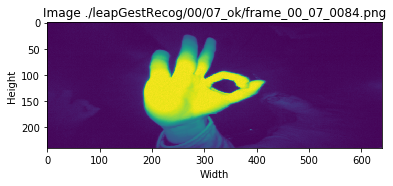

In [0]:
plot_image(imagepaths[0]) #We plot the first image from our imagepaths array

Now that we loaded the images and checked if it's everything we expected, we have to prepare the images to train the algorithm. We have to load all the images into an array that we will call **X** and all the labels (crater/non-crater) into another array called **y**.

In [0]:
X = [] # Image data
y = [] # Labels

for path in imagepaths:
  img = cv2.imread(path) # Reads image and returns np.array
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Converts into the corret colorspace (GRAY)
  img = cv2.resize(img, (320, 120)) # Reduce image size so training can be faster
  X.append(img) # Append to X
  
  category = path.split("/")[3]
  label = int(category.split("_")[0][1]) # We need to convert 10_down to 00_down, or else it crashes
  y.append(label)

# Turn X and y into np.array to speed up train_test_split
X = np.array(X, dtype="uint8")
X = X.reshape(len(imagepaths), 120, 320, 1) # Needed to reshape so CNN knows it's different images
y = np.array(y)

print("Images loaded: ", len(X))
print("Labels loaded: ", len(y))

print(y[0], imagepaths[0])

Images loaded:  2000
Labels loaded:  2000
7 ./leapGestRecog/00/07_ok/frame_00_07_0084.png


In [0]:
ts = 0.3 # Percentage of images that we want to use for testing. The rest is used for training.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=ts, random_state=42)

## Creating Model

In [0]:
# Import of keras model and hidden layers for our convolutional network
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Dense, Flatten

In [0]:
# Construction of model
model = Sequential()
model.add(Conv2D(32, (5, 5), strides=(2, 2), activation='relu', input_shape=(120, 320, 1))) 
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu')) 
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))

In [0]:
# Configures the model for training
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
# Trains the model for a given number of epochs (iterations on a dataset) and validates it.
model.fit(X_train, y_train, epochs=5, batch_size=64, verbose=2, validation_data=(X_test, y_test))

Train on 1400 samples, validate on 600 samples
Epoch 1/5
 - 34s - loss: 6.9578 - acc: 0.4150 - val_loss: 0.5126 - val_acc: 0.8933
Epoch 2/5
 - 33s - loss: 0.0816 - acc: 0.9857 - val_loss: 0.0082 - val_acc: 0.9983
Epoch 3/5
 - 33s - loss: 0.0019 - acc: 0.9993 - val_loss: 0.0074 - val_acc: 0.9983
Epoch 4/5
 - 33s - loss: 3.1660e-04 - acc: 1.0000 - val_loss: 6.6929e-04 - val_acc: 1.0000
Epoch 5/5
 - 34s - loss: 5.8203e-05 - acc: 1.0000 - val_loss: 3.8153e-04 - val_acc: 1.0000


## Testing Model


In [0]:
test_loss, test_acc = model.evaluate(X_test, y_test)

print('Test accuracy: {:2.2f}%'.format(test_acc*100))

600/600 [==============================] - 4s 6ms/step
Test accuracy: 100.00%


In [0]:
predictions = model.predict(X_test)

In [0]:
np.argmax(predictions[0]), y_test[0] # If same, got it right

(3, 3)

In [0]:
def validate_9_images(predictions_array, true_label_array, img_array):
  # Array for pretty pretty printing and then figure size
  class_names = ["down", "palm", "l", "fist", "fist_moved", "thumb", "index", "ok", "palm_moved", "c"] 
  plt.figure(figsize=(15,5))
  
  for i in range(1, 10):
    # Just assigning variables
    prediction = predictions_array[i]
    true_label = true_label_array[i]
    img = img_array[i]
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    
    # Plot in a good way
    plt.subplot(3,3,i)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(prediction) # Get index of the predicted label from prediction
    
    # Change color of title
    if predicted_label == true_label:
      color = 'blue'
    else:
      color = 'red'

    plt.xlabel("Predicted: {} {:2.0f}% (True: {})".format(class_names[predicted_label],
                                  100*np.max(prediction),
                                  class_names[true_label]),
                                  color=color)
  plt.show()

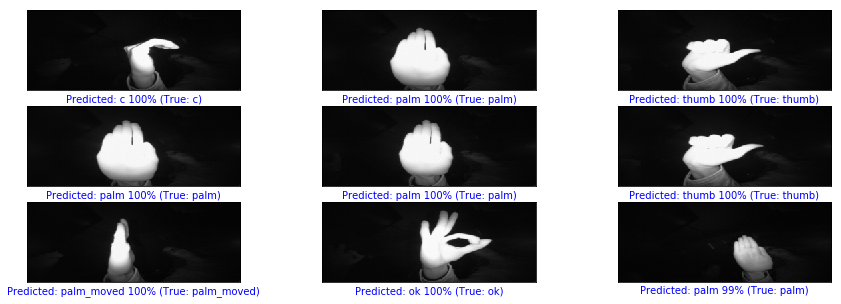

In [0]:
validate_9_images(predictions, y_test, X_test)